In [1]:
import numpy as np
from neuron import h, gui
import os
import sys
import time
import brainstate 
import braintools 
import brainunit as u
import jax
import matplotlib.pyplot as plt
import braincell as dx
import jax.numpy as jnp
from scipy.interpolate import interp1d

## load gol mor
parent_folder_path = os.path.join(os.getcwd(), 'golgi_NEURON')
sys.path.append(parent_folder_path)
from GOL import Golgi_morpho_1

## load gol mod
current_dir = os.getcwd()
mod_path = os.path.join(current_dir, 'golgi_NEURON', 'mod_gol')
os.system(f'nrnivmodl {mod_path}')

current_dir = os.path.dirname(os.path.abspath('.'))
project_root = os.path.abspath(os.path.join(current_dir, '..', '..'))
dendritex_path = os.path.join(project_root, 'braincell')
sys.path.insert(0, dendritex_path)

brainstate .environ.set(precision=64)
#jax.config.update("jax_disable_jit", True)

# set visible GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
devices = jax.devices()
print("available devices:", devices)

--No graphics will be displayed.
/home/swl/anaconda3/envs/braincell/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


/home/swl/braincell/examples/golgi_model
Mod files: "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/Cav12.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/Cav13.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/Cav2_3.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/Cav3_1.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/cdp5StCmod.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol/GOLGI_Ampa_mossy_det_vi.mod" "/home/swl/braincell/examples/golgi_model/golgi_NEURON/mod_gol//home/swl/braincell/examples/golgi_model/gol

In [2]:
soma = h.Section(name='soma')
soma.L = 20  
soma.diam = 20  

soma.insert('HCN1')
h.psection()

## stim
stim = h.IClamp(soma(0.5))
stim.delay = 0  
stim.dur = 20  
stim.amp = 0.02

## record
v = h.Vector()  
t = h.Vector() 
o_fast = h.Vector()  
o_slow = h.Vector()  

v.record(soma(0.5)._ref_v)  
t.record(h._ref_t)  
o_fast.record(soma(0.5)._ref_o_fast_HCN1)
o_slow.record(soma(0.5)._ref_o_slow_HCN1)

## run
h.celsius = 22
h.dt = 0.01
h.v_init = -55
h.finitialize(-55)
#cell.soma[0](0.5).v = -65
h.continuerun(20)

soma { nseg=1  L=20  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=20}
	insert capacitance { cm=1}
	insert HCN1 { gbar_HCN1=5e-05 Erev_HCN1=-20 Q10_diff_HCN1=1.5 Q10_channel_HCN1=3}
}


0.0

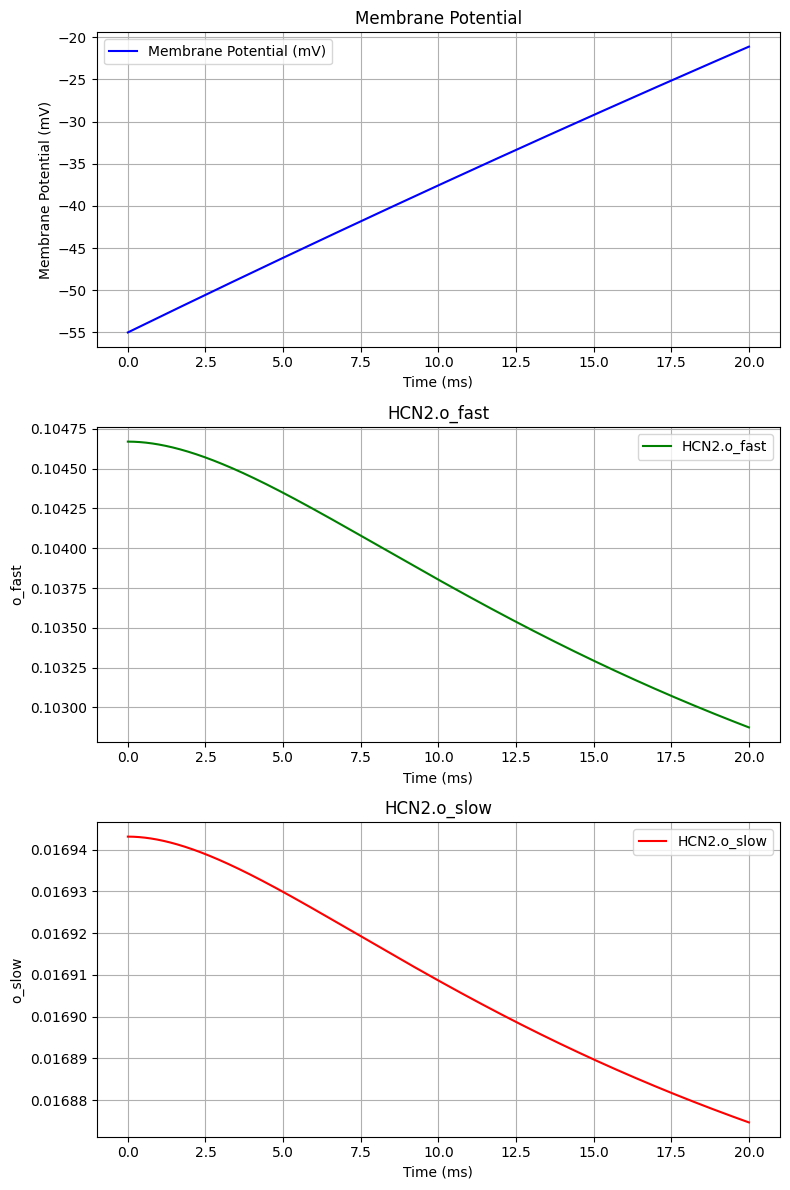

In [3]:

# 绘制结果
plt.figure(figsize=(8, 12))

# 子图 1：膜电位随时间的变化
plt.subplot(3, 1, 1)
plt.plot(t, v, label='Membrane Potential (mV)', color='blue')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential')
plt.grid()
plt.legend()

# 子图 2：o_fast 随时间的变化
plt.subplot(3, 1, 2)
plt.plot(t, o_fast, label='HCN2.o_fast', color='green')
plt.xlabel('Time (ms)')
plt.ylabel('o_fast')
plt.title('HCN2.o_fast')
plt.grid()
plt.legend()

# 子图 3：o_slow 随时间的变化
plt.subplot(3, 1, 3)
plt.plot(t, o_slow, label='HCN2.o_slow', color='red')
plt.xlabel('Time (ms)')
plt.ylabel('o_slow')
plt.title('HCN2.o_slow')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class Single(dx.neuron.MultiCompartment):
    def __init__(self, size, connection, Ra, cm, diam, L, el=0, gl=0, gh1=0, gh2=0, ek=-80, gkv11=0, gkv34=0, gkv43=0, ena=50, gnarsg=0, gcagrc=0, gcav23=0, gcav31=0, gkca31=0, Gl=0, El=-65, V_init=-55, solver = 'exp_euler'):
        super().__init__(
            size=size,
            connection=connection,
            Ra=Ra * u.ohm * u.cm,
            cm=cm * u.uF / u.cm ** 2,
            diam=diam * u.um,
            L=L * u.um,
            V_th= 20. * u.mV,
            V_initializer=brainstate.init.Constant(V_init * u.mV),
            spk_fun=brainstate.surrogate.ReluGrad(),
            solver = solver,
            Gl = Gl * u.mS / (u.cm ** 2),
            El = El * u.mV
        )
        self.IL = dx.channel.IL(self.varshape, E= el * u.mV, g_max= gl * u.mS / (u.cm ** 2))
        self.Ih1 = dx.channel.Ih1_Ma2020(self.varshape, E= -20. * u.mV, g_max= gh1 * u.mS / (u.cm ** 2))
        self.Ih2 = dx.channel.Ih2_Ma2020(self.varshape, E= -20. * u.mV, g_max= gh2 * u.mS / (u.cm ** 2))

        self.k = dx.ion.PotassiumFixed(self.varshape, E= ek * u.mV)
        self.k.add(IK_1 = dx.channel.IKv11_Ak2007(self.varshape, g_max= gkv11 * u.mS / (u.cm ** 2)))
        #self.k.add(IK_2 = dx.channel.IKv34_Ma2020(self.varshape, g_max= gkv34 * u.mS / (u.cm ** 2)))
        #self.k.add(IK_3 = dx.channel.IKv43_Ma2020(self.varshape, g_max= gkv43 * u.mS / (u.cm ** 2)))

        #self.na = dx.ion.SodiumFixed(self.varshape, E= ena * u.mV)
        #self.na.add(INa =dx.channel.INa_Rsg(self.varshape, g_max= gnarsg * u.mS / (u.cm ** 2)))#
        #self.na.add(INa =dx.channel.INa_HH1952(self.varshape))
        
        #self.ca = dx.ion.CalciumDetailed(size, C_rest=5e-5 * u.mM, tau=10. * u.ms, d=0.5 * u.um)
        #self.ca = dx.ion.CalciumFixed(self.varshape, E=137.* u.mV, C =5e-5 * u.mM)
        #self.ca.add(ICaL=dx.channel.ICaGrc_Ma2020(self.varshape, g_max=gcagrc * (u.mS / u.cm ** 2)))
        #self.ca.add(ICaL=dx.channel.ICav23_Ma2020(self.varshape, g_max=gcav23 * (u.mS / u.cm ** 2)))
        #self.ca.add(ICaL=dx.channel.ICav31_Ma2020(self.varshape, g_max=gcav31 * (u.mS / u.cm ** 2)))

        #self.kca = dx.MixIons(self.k, self.ca)
        #self.kca.add(IKca = dx.channel.IKca1_1_Ma2020(self.varshape, g_max=gkca31 * u.mS / (u.cm ** 2)))

    def step_run(self, t, inp):
        with brainstate.environ.context(t=t):
            self.update(inp)
            return self.V.value ,(self.Ih1.p.value , self.Ih1.q.value)
        
## run 
def BraincellRun(neu,I, dt):
    ## time
    brainstate.environ.set(dt= dt * u.ms)
    times = u.math.arange(I.shape[0]) * brainstate.environ.get_dt()
    ## init and reset
    neu.init_state()
    neu.reset_state()
    ## run
    vs, p = brainstate.compile.for_loop(neu.step_run, times, I)

    return times.to_decimal(u.ms), vs.to_decimal(u.mV),p

## different input func
def step_input(num, dur, amp, dt):
    brainstate.environ.set(dt= dt * u.ms)
    value = jnp.zeros((len(dur),num))
    for i in range(len(value)):
        value = value.at[i, 0].set(amp[i])

    I = braintools.input.section_input(values=value, durations= dur * u.ms) * u.nA
    return I

In [ ]:
Ra = 100*np.ones(3) ; cm =1*np.ones(3) ; L =20*np.ones(3); diam =20*np.ones(3); connection = [(1,2)]
single_cell = Single(size= (1,3), connection=connection, Ra=Ra, cm=cm, diam=diam, L=L,gh1=5e-2,solver='cn_rk4')
I = step_input(num=3, dur=[20,0,0], amp=[0.02,0.,0], dt=0.01)
t1, v1, p  = BraincellRun(neu=single_cell, I=I, dt = 0.01)

# 绘制结果
plt.figure(figsize=(8, 12))

# 子图 1：膜电位随时间的变化
plt.subplot(3, 1, 1)
plt.plot(t1, v1[:,:,0], label='Braincell', color='blue')
plt.plot(t, v, label='NEURON')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')
plt.title('Membrane Potential')
plt.grid()
plt.legend()

# 子图 2：o_fast 随时间的变化
plt.subplot(3, 1, 2)
plt.plot(t1, p[0][:,:,0], label='Braincell', color='green')
plt.plot(t, o_fast, label='NEURON')
plt.xlabel('Time (ms)')
plt.ylabel('o_fast')
#plt.title('HCN.o_fast')
plt.grid()
plt.legend()

# 子图 3：o_slow 随时间的变化
plt.subplot(3, 1, 3)
plt.plot(t1, p[1][:,:,0], label='Braincell', color='red')
plt.plot(t, o_slow, label='NEURON')
plt.xlabel('Time (ms)')
plt.ylabel('o_slow')
#plt.title('HCN2.o_slow')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
plt.plot(np.array(t)[1:],np.abs((np.array(v)[1:].reshape(2000)-np.array(v1[:,:,0].reshape(2000)))))
plt.xlabel('Time (ms)')
plt.ylabel('(mV)')
plt.title('Error of Membrane Potential ')
plt.grid()